# Titanic Competition - Deep Learning

In [1]:
# Hyperparameters
BATCH_SIZE = 64
EPOCHS = 100
LR = 0.01
MOMENTUM = 0.9
DECAY = 0.01

In [2]:
# Setup plotting
import matplotlib.pyplot as plt

plt.style.use("seaborn-v0_8-whitegrid")
# Set Matplotlib defaults
plt.rc("figure", autolayout=True)
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=18,
    titlepad=10,
)
plt.rc("animation", html="html5")

import numpy as np  # linear algebra
import pandas as pd  # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score

from statistics import mean

import os

from utils import (
    preprocess_data,
    MyModel,
    model_init,
)

## Preprocessing

In [3]:
# Read the data
train_data = pd.read_csv("../input/train.csv").set_index("PassengerId")
test_data = pd.read_csv("../input/test.csv").set_index("PassengerId")

X, y, X_test = preprocess_data(
    train_data,
    test_data,
    label_value="Survived",
)

## Define the model

In [4]:
input_shape = [X.shape[1]]
model = MyModel()

## Start testing

In [5]:
# Define the K-Fold cross-validator (K=5 in this example)
kf = KFold(n_splits=10, shuffle=True, random_state=42)

# Perform K-Fold Cross-Validation manually
binary_accuracies = {}
losses = {}
val_binary_accuracies = {}
val_losses = {}

models = {}

In [6]:
k_index = 0

for train_index, val_index in kf.split(X):
    # Split the data into training and testing sets
    X_train, X_val = X[train_index], X[val_index]

    y_train, y_val = y[train_index], y[val_index]

    # Init the model in every iteration
    model, early_stopping, lrs = model_init(MyModel(), LR, MOMENTUM, DECAY)

    history = model.fit(
        X_train,
        y_train,
        validation_data=(X_val, y_val),
        batch_size=BATCH_SIZE,
        epochs=EPOCHS,
        callbacks=[early_stopping, lrs],
    )

    binary_accuracies[k_index] = history.history["binary_accuracy"]
    losses[k_index] = history.history["loss"]
    val_binary_accuracies[k_index] = history.history["val_binary_accuracy"]
    val_losses[k_index] = history.history["val_loss"]

    models[k_index] = model

    k_index += 1

Epoch 1/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - binary_accuracy: 0.5862 - loss: 0.8286 - val_binary_accuracy: 0.7556 - val_loss: 0.5916 - learning_rate: 0.0100
Epoch 2/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - binary_accuracy: 0.8028 - loss: 0.4986 - val_binary_accuracy: 0.6333 - val_loss: 0.6163 - learning_rate: 0.0100
Epoch 3/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - binary_accuracy: 0.7862 - loss: 0.4618 - val_binary_accuracy: 0.6000 - val_loss: 0.6277 - learning_rate: 0.0100
Epoch 4/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - binary_accuracy: 0.7948 - loss: 0.4710 - val_binary_accuracy: 0.6000 - val_loss: 0.6298 - learning_rate: 0.0100
Epoch 5/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - binary_accuracy: 0.8238 - loss: 0.4455 - val_binary_accuracy: 0.6000 - val_loss: 0.6128 - learning_rate: 0.0100
Epoch 6/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - binary_accuracy: 0.8187 - loss: 0.4484 - val_binary_accuracy: 0.6111 - val_loss: 0.5992 - learning_rate: 0.0100
Epoch 7/1

In [7]:
print(
    (
        "Last average accuracy: {:0.4f}"
        + "\nMax average accuracy: {:0.4f}"
        + "\nMax accuracy: {:0.4f}"
    ).format(
        mean([accs[-1] for accs in val_binary_accuracies.values()]),
        mean([max(accs) for accs in val_binary_accuracies.values()]),
        max([max(accs) for accs in val_binary_accuracies.values()]),
    )
)

print(
    (
        "\nLast average loss: {:0.4f}"
        + "\nMin average loss: {:0.4f}"
        + "\nMin loss: {:0.4f}"
    ).format(
        mean([loss[-1] for loss in val_losses.values()]),
        mean([min(loss) for loss in val_losses.values()]),
        min([min(loss) for loss in val_losses.values()]),
    )
)


max_key = None
max_value = float("-inf")

for key, value in val_binary_accuracies.items():
    if value[-1] > max_value:
        max_value = value[-1]
        max_key = key


print(
    ("\nBest run: {}" + "\nLast loss: {:0.4f}" + "\nBest loss: {:0.4f}").format(
        max_key, max_value, max(val_binary_accuracies[max_key])
    )
)

Last average accuracy: 0.8226
Max average accuracy: 0.8372
Max accuracy: 0.9213

Last average loss: 0.4307
Min average loss: 0.4201
Min loss: 0.2989

Best run: 5
Last loss: 0.8876
Best loss: 0.8876


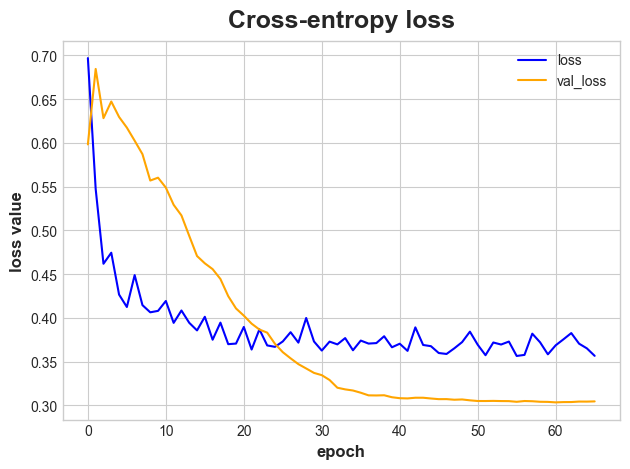

In [8]:
# Plotting loss
plt.plot(losses[max_key], label="loss", color="blue")
plt.plot(val_losses[max_key], label="val_loss", color="orange")

# Adding labels and title
plt.xlabel("epoch")
plt.ylabel("loss value")
plt.title("Cross-entropy loss")

# Adding a legend
plt.legend()

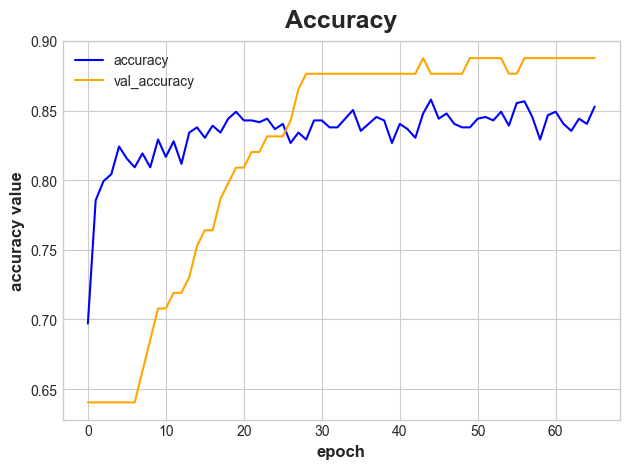

In [9]:
# Plotting loss
plt.plot(binary_accuracies[max_key], label="accuracy", color="blue")
plt.plot(val_binary_accuracies[max_key], label="val_accuracy", color="orange")

# Adding labels and title
plt.xlabel("epoch")
plt.ylabel("accuracy value")
plt.title("Accuracy")

# Adding a legend
plt.legend()

## Submit prediction

In [10]:
# Preprocessing of training data, fit model
model, early_stopping, lrs = model_init(MyModel(), LR, MOMENTUM, DECAY)
model.fit(
    X,
    y,
    batch_size=64,
    epochs=50,
    callbacks=[early_stopping, lrs],
)

# Preprocessing of validation data, get predictions
y_pred = (model.predict(X_test) > 0.5).astype(np.intc)
predictions = np.concatenate(y_pred)

# Saving the predictions
output = pd.DataFrame({"PassengerId": test_data.index, "Survived": predictions})
if not os.path.isdir("output/"):
    os.mkdir("output/")
output.to_csv("output/submission.csv", index=False)

print("Your submission was successfully saved!")

Epoch 1/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - binary_accuracy: 0.6116 - loss: 0.8163 - learning_rate: 0.0100
Epoch 2/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - binary_accuracy: 0.7700 - loss: 0.5482 - learning_rate: 0.0100
Epoch 3/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - binary_accuracy: 0.7880 - loss: 0.4634 - learning_rate: 0.0100
Epoch 4/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - binary_accuracy: 0.8176 - loss: 0.4346 - learning_rate: 0.0100
Epoch 5/50


c:\Users\kkleist\OneDrive - DXC Production\Desktop\github\Titanic-Competition\titanic-comp-venv\lib\site-packages\keras\src\callbacks\early_stopping.py:155: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: binary_accuracy,loss
  current = self.get_monitor_value(logs)


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - binary_accuracy: 0.8205 - loss: 0.4220 - learning_rate: 0.0100
Epoch 6/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - binary_accuracy: 0.8171 - loss: 0.4152 - learning_rate: 0.0100
Epoch 7/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - binary_accuracy: 0.8250 - loss: 0.3936 - learning_rate: 0.0100
Epoch 8/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - binary_accuracy: 0.8246 - loss: 0.3943 - learning_rate: 0.0100
Epoch 9/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - binary_accuracy: 0.8260 - loss: 0.4048 - learning_rate: 0.0050
Epoch 10/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - binary_accuracy: 0.8245 - loss: 0.3897 - learning_rate: 0.0050
Epoch 11/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - binary_accuracy: 0.8383 - loss: 0.3743 - learning_rate: 0.0050
Epoch 12/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - binary_accuracy: 0.8375 - loss: 0.3690 - learning_rate: 0.0050
Epoch 13/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - binary_accuracy: 0.8276 - loss: 0.4